In [49]:
!pip install Bio
!pip install pandas openpyxl

In [50]:
from Bio import SeqIO
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB


In [51]:
def naive_string_match(text, pattern):
    n = len(text)
    m = len(pattern)
    for i in range(n - m + 1):
        if text[i:i + m] == pattern:
            return True
    return False

def label_actn3_genotype(allele1, allele2):
    r_patterns = ["CGA", "CGC", "CGG", "CGT", "AGA", "AGG"]
    label1 = "R" if any(naive_string_match(allele1[i:i + 3], r) for i in range(0, len(allele1) - 2) for r in r_patterns) else "X"
    label2 = "R" if any(naive_string_match(allele2[i:i + 3], r) for i in range(0, len(allele2) - 2) for r in r_patterns) else "X"
    if label1 == "R" and label2 == "R":
        return "RR"
    elif label1 == "X" and label2 == "X":
        return "XX"
    else:
        return "RX"

def read_fasta_from_file(fasta_file_path):
    sequences = {}
    with open(fasta_file_path, "r") as fasta_file:
        for record in SeqIO.parse(fasta_file, "fasta"):
            sequences[record.id] = str(record.seq).upper()
    return sequences

fasta_file_path = "/content/gene.fna"

sequences = read_fasta_from_file(fasta_file_path)

id = "NC_000011.10:66546395-66563334"
id2 = "NC_060935.1:66542637-66559581"

if id not in sequences:
    raise ValueError(f"Sequence {id} not found in gene.fna. Check FASTA headers: {list(sequences.keys())}")
if id2 not in sequences:
    raise ValueError(f"Sequence {id2} not found in gene.fna. Check FASTA headers: {list(sequences.keys())}")

allele1 = sequences[id]
allele2 = sequences[id2]

if len(allele1) < 1731:
    raise ValueError(f"Wild-type sequence is too short: {len(allele1)} nucleotides")

print(f"Allele 1 length: {len(allele1)}")
print(f"Allele 2 length: {len(allele2)}")

try:
    genotype = label_actn3_genotype(allele1, allele2)
    print(f"Genotype: {genotype}")
except ValueError as e:
    print(f"Error: {e}")

Allele 1 length: 16940
Allele 2 length: 16945
Genotype: RR


# Model

In [52]:

df = pd.read_excel('/content/Dataset.xlsx', engine='openpyxl')
print(df.head())


  label  Maximal velocity Sq  Maximal Acceleration Sq  \
0    XX             2.517934                 25.87963   
1    XX             2.464290                 18.89350   
2    XX             2.370020                 27.78922   
3    XX             2.545390                 22.50343   
4    XX             2.738810                 25.69863   

   Peak vertical ground reaction force on concentric phase  Sq  \
0                                            1044.60             
1                                             864.66             
2                                             770.81             
3                                             602.96             
4                                            1364.02             

   Jump Height  Sq  Flight time/Take off time SQ  \
0           40.694                         0.508   
1           38.847                         0.510   
2           37.860                         0.435   
3           36.937                         0.498   


In [53]:
print(df.isnull().sum())

label                                                           0
Maximal velocity Sq                                             4
Maximal Acceleration Sq                                         4
Peak vertical ground reaction force on concentric phase  Sq     4
Jump Height  Sq                                                 4
Flight time/Take off time SQ                                    4
Rate of force development  Sq                                   4
Power SQ                                                        4
Maximal velocity CMJ                                            4
Maximal Acceleration CMJ                                        4
Peak vertical ground reaction force in concentric phase CMJ     4
Peak vertical ground reaction force in eccentric phase CMJ      4
Jump Height CMJ                                                 4
Rate of foce development of conentric phase CMJ                 4
Power CMJ                                                       4
Maximal ve

In [54]:

df_filled = df.fillna(df.mean(numeric_only=True))
print(df_filled.isnull().sum())

label                                                          0
Maximal velocity Sq                                            0
Maximal Acceleration Sq                                        0
Peak vertical ground reaction force on concentric phase  Sq    0
Jump Height  Sq                                                0
Flight time/Take off time SQ                                   0
Rate of force development  Sq                                  0
Power SQ                                                       0
Maximal velocity CMJ                                           0
Maximal Acceleration CMJ                                       0
Peak vertical ground reaction force in concentric phase CMJ    0
Peak vertical ground reaction force in eccentric phase CMJ     0
Jump Height CMJ                                                0
Rate of foce development of conentric phase CMJ                0
Power CMJ                                                      0
Maximal velocity DJ      

In [55]:
X = df_filled.drop(columns=['label'])
y = df_filled['label']

In [56]:

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [57]:
print(y[:50])


[2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


<ipython-input-58-f117912a8156>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(classes))


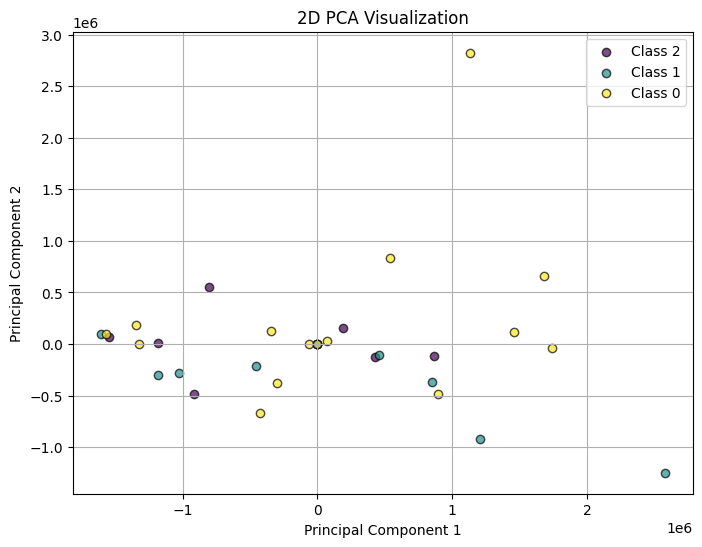

In [58]:

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['label'] = y


plt.figure(figsize=(8, 6))


classes = pca_df['label'].unique()
colors = plt.cm.get_cmap('viridis', len(classes))

for i, cls in enumerate(classes):
    subset = pca_df[pca_df['label'] == cls]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Class {cls}', alpha=0.7, edgecolors='k', color=colors(i))

plt.title('2D PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [59]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [60]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

RF

In [ ]:

rf = RandomForestClassifier(random_state=42)


param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None, 0.5],
    'bootstrap': [True, False]
}



grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)


grid_search.fit(X_train, y_train)


print("Best Random Forest parameters:", grid_search.best_params_)


best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)


print("Train accuracy:", best_rf.score(X_train, y_train))
print("Test accuracy:", accuracy_score(y_test, y_pred))


print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KNN

In [ ]:



knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}


knn_grid_search = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)


knn_grid_search.fit(X_train, y_train)


print("Best KNN parameters:", knn_grid_search.best_params_)
best_knn = knn_grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("Train accuracy:", best_knn.score(X_train, y_train))
print("Test accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))


DT

In [ ]:



dt = DecisionTreeClassifier(random_state=42)


dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


dt_grid_search = GridSearchCV(
    estimator=dt,
    param_grid=dt_param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)


dt_grid_search.fit(X_train, y_train)


print("Best Decision Tree parameters:", dt_grid_search.best_params_)
best_dt = dt_grid_search.best_estimator_


y_pred_dt = best_dt.predict(X_test)
print("Train accuracy:", best_dt.score(X_train, y_train))
print("Test accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))


NB

In [ ]:



gnb = GaussianNB()
gnb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}


gnb_grid_search = GridSearchCV(
    estimator=gnb,
    param_grid=gnb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)


gnb_grid_search.fit(X_train, y_train)


print("Best Naive Bayes parameters:", gnb_grid_search.best_params_)
best_gnb = gnb_grid_search.best_estimator_
y_pred_gnb = best_gnb.predict(X_test)

print("Train accuracy:", best_gnb.score(X_train, y_train))
print("Test accuracy:", accuracy_score(y_test, y_pred_gnb))
print("Classification Report:\n", classification_report(y_test, y_pred_gnb))


In [ ]:


models = ['Random Forest', 'KNN', 'Decision Tree', 'Naive Bayes']
train_accuracies = [
    best_rf.score(X_train, y_train),
    best_knn.score(X_train, y_train),
    best_dt.score(X_train, y_train),
    best_gnb.score(X_train, y_train)
]


plt.figure(figsize=(10, 6))
bars = plt.bar(models, train_accuracies, color=['skyblue', 'pink', 'lightgreen', 'purple'])
plt.ylim(0, 1.05)
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Comparison of Classifiers')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()
